In [1]:
from torch.utils.data import Dataset
# from modules.utils import load_json
import numpy as np
from PIL import Image
import os
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix 
import pandas as pd
import os
import sys
from torch import nn
import timm
from datetime import datetime, timezone, timedelta 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import logging
import torch
import csv
import torchvision.transforms as transforms
import numpy as np
import torch
import torch.optim as optim
from time import time
from tqdm import tqdm
from torch.nn import functional as F
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch.optim as optim
from itertools import product
import logging
import random
import pickle
import shutil
import json
import yaml
import csv
import os 
from scipy.stats import entropy

In [3]:
class CowDataset(Dataset):
    def __init__(self, img_folder, dfpath, transform):
        self.df = pd.read_csv(dfpath, usecols=['imname','grade'],dtype={'grade':str})
        self.label_encoding = {'1++':0, '1+':1, '1':2, '2':3, '3':4}
        self.img_folder = img_folder
        self.transforms = transform
        
        self.image_names = self.df['imname']
        self.labels = self.df['grade']
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        impath = os.path.join(self.img_folder, self.image_names[index])
        img = Image.open(impath).convert('RGB')
        img = self.transforms(img)
        target = self.labels[index]
        lbl = self.label_encoding[target]
        
        return img,lbl

class TestDataset(Dataset):
    def __init__(self, img_folder, dfpath):
        self.df = pd.read_csv(dfpath, usecols=['imname'],dtype={'imname':str})
        self.img_folder = img_folder
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456,0.406],[0.229,0.224,0.225])
        ])
        self.image_names = self.df['imname']
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        impath = os.path.join(self.img_folder, self.image_names[index])
        img = Image.open(impath)
        img = self.transforms(img)
        filename = self.image_names[index]
        
        return img,filename

In [4]:
class ConfusionRateLoss(nn.Module):
    def __init__(self):
        super(ConfusionRateLoss, self).__init__() 
        self.k = 3
    
    def get_cr_matrix(self, y_true, y_pred):
        y_pred_int = torch.argmax(y_pred)
        c_matrix = confusion_matrix(y_true.cpu().detach().numpy(), y_pred_int.cpu().detach().numpy())
        denom = c_matrix + np.transpose(c_matrix)
        cr_matrix = c_matrix / denom
        for i in range(len(cr_matrix)):
            cr_matrix[i, i] = 0
        return cr_matrix
    
    def forward(self, y_true, y_pred):
        cr_matrix = self.get_cr_matrix(y_true, y_pred)
        ce_loss = F.cross_entropy(y_pred, y_true)
        
        losses = []
        for i in range(len(y_true)):
            y, y_hat = y_true[i].item(), y_pred[i].item()
            if y != y_hat:
                ent = entropy(cr_matrix[y, y_hat], cr_matrix[y_hat, y]) 
                losses.append(ent)
        ent_loss = sum(losses) / len(losses)
        return ce_loss + self.k * ce_loss * ent_loss

In [5]:
class FocalLoss(nn.Module):
    def __init__(self):
        super(FocalLoss, self).__init__()
        
    def forward(self, inputs, targets, alpha, gamma):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        BCE = F.binary_cross_entropy(inputs, targets, reduction='none')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
        
        return focal_loss  

class KappaScore:
    def __init__(self):
        super(KappaScore, self).__init__()

    def quadratic_weighted_kappa(self, c_matrix):
        numer = 0.0
        denom = 0.0

        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[1]):
                n = c_matrix.shape[0]
                wij = ((i-j)**2.0)/((n-1)**2)
                oij = c_matrix[i,j]
                eij = c_matrix[i,:].sum() * c_matrix[:,j].sum()/c_matrix.sum()
                numer += wij*oij
                denom += wij*eij
        return 1.0 - numer/denom
    
    def get_score(self, y_true, y_pred):
        c_matrix = confusion_matrix(y_true, y_pred)
        kappa = self.quadratic_weighted_kappa(c_matrix)
        return kappa

class F1Score:
    
    def __init__(self, average):
        self.average = average
        
    def get_score(self, y_true, y_pred):
        return f1_score(y_true, y_pred, average=self.average) 

class MultiLoss(nn.Module):
    def __init__(self):
        super(MultiLoss, self).__init__()
        self.kappa_metric = KappaScore()
        self.alpha = 0.5
        
    def forward(self, inputs, targets): 
        ce_loss = F.cross_entropy(inputs, targets)

        inputs = inputs.argmax(dim=1) 
        kappa_score = self.kappa_metric.get_score(inputs.cpu().tolist(), targets.cpu().tolist())
        if kappa_score > 0:
            kp_loss = 1 / self.kappa_metric.get_score(inputs.cpu().tolist(), targets.cpu().tolist())
        else:
            kp_loss = 1
        multi_loss = self.alpha * ce_loss + (1-self.alpha) * kp_loss
        
        return multi_loss

In [6]:
import math
from torch.optim import Optimizer
class _LRScheduler(object):
    def __init__(self, optimizer, last_epoch=-1):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
            last_epoch = 0
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an optimizer".format(i))
        self.base_lrs = list(map(lambda group: group['initial_lr'], optimizer.param_groups))
        self.step(last_epoch)

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the schedulers state.
        Arguments:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def get_lr(self):
        raise NotImplementedError

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
        self.T_cur = last_epoch
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [7]:
def cut(W,H,lam):
        
    ######define the size of box######
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat) 
    ######define the size of box######
    
    #####randomly choose where to cut#####
    cx = np.random.randint(W) # uniform distribution
    cy = np.random.randint(H)
    #####randomly choose where to cut#####

    bbx1 = np.clip(cx - cut_w // 2, 0, W) # Cut, return coordinates of the box 
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [8]:
class Trainer():
    
    def __init__(self, model, loss, optimizer, device):
        self.model = model 
        self.optimizer = optimizer
#         self.scheduler = CosineAnnealingWarmUpRestarts(self.optimizer, T_0=50, T_mult=1, eta_max=0.1, T_up=10, gamma=0.5)
        # self.optimizer = optim.Adam(params=model.parameters(),lr=0, weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=100, eta_min=0)
        # self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.5)
        self.loss = loss
        self.metrics = {'accuracy':accuracy_score, 
                        'f1macro':F1Score(average='macro').get_score, 
                        'kappa':KappaScore().get_score}
        self.device = device  
        
        # History
        self.loss_sum = 0 # Epoch loss sum
        self.loss_mean = 0 # epoch loss mean
        self.filenames = list()
        self.y = list()
        self.y_preds = list()
        self.score_dict = dict()
        self.elapsed_time = 0
        
    def train(self, mode, dataloader, epoch_index=0):
        start_timestamp = time()
        self.model.train() if mode == 'train' else self.model.eval() 
        
        for batch_index, (x,y) in enumerate(tqdm(dataloader)):
            x,y = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.long)
            
            if mode == 'train':
                # cutmix
                lam = np.random.beta(1.0, 1.0)
                rand_index = torch.randperm(x.size()[0])
                shuffled_labels = y[rand_index]
                bbx1, bby1, bbx2, bby2 = cut(x.shape[2], x.shape[3], lam) # define a box to cut and mix
                x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.shape[-1] * x.shape[-2]))

                # Inference
                y_pred = self.model(x) 

                # Loss 
                loss = self.loss(y_pred, y) * lam + self.loss(y_pred, shuffled_labels)*(1.0-lam)
                # loss = self.loss(y_pred, y)             
                # loss = F.cross_entropy(y_pred, y1).item() * lamb + F.cross_entropy(y_pred, y2).item() * (1.0-lamb)  
            else:
                # Inference                
                y_pred = self.model(x) 
                loss = self.loss(y_pred, y)             
            
            # Update
            if mode == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                
                # with amp.scale_loss(loss, optimizer) as scaled_loss:
                #     scaled_loss.backward() 
                 
                    
                self.optimizer.step()
                self.scheduler.step()
            
            elif mode in ['val','test']:
                pass
            else:
                raise ValueError('Mode should be either train, val, or test')
            
            # History
            #self.filenames += filename
            self.loss_sum += loss.item()
            self.y_preds.append(y_pred.argmax(dim=1))
            self.y.append(y)  
            
        # Epoch history
        self.loss_mean = self.loss_sum / len(dataloader)
        
        # Metric
        self.y_preds = torch.cat(self.y_preds, dim=0).cpu().tolist()
        self.y = torch.cat(self.y, dim=0).cpu().tolist()
        
        for metric_name, metric_func in self.metrics.items():
            score = metric_func(self.y, self.y_preds)
            self.score_dict[metric_name] = score
        
        # Elapsed time
        end_timestamp = time()
        self.elapsed_time = end_timestamp - start_timestamp
        
    def clear_history(self):
        self.loss_sum = 0
        self.loss_mean = 0
        self.y_preds = list()
        self.y = list()
        self.score_dict = dict()
        self.elapsed_time = 0 

In [9]:
class Recorder():
    def __init__(self,
                record_dir:str,
                model: object,
                optimizer: object,
                scheduler: object):
        self.record_dir = record_dir
        self.plot_dir = os.path.join(record_dir, 'plots')
        self.record_filepath = os.path.join(self.record_dir, 'record.csv')
        self.weight_path = os.path.join(record_dir, 'model.pt')
         
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler 
        
        os.makedirs(self.plot_dir, exist_ok = True)
        
    def set_model(self, model: 'model'):
        self.model = model 
        
    def create_record_directory(self):
        os.makedirs(self.record_dir, exist_ok=True) 
        
    def add_row(self, row_dict: dict):
        fieldnames = list(row_dict.keys())
        
        with open(self.record_filepath, newline='', mode='a') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            
            if f.tell() == 0:
                writer.writeheader()
                
            writer.writerow(row_dict) 
            
    def save_weight(self, epoch:int) -> None:  
        check_point = {
            'epoch': epoch + 1,
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict() if self.scheduler else None,
        }
        torch.save(check_point, self.weight_path)
        msg = f"Recorder, epoch {epoch} Model saved: {self.weight_path}" 
        
    def save_plot(self, plots: list):

        record_df = pd.read_csv(self.record_filepath)
        current_epoch = record_df['epoch_index'].max()
        epoch_range = list(range(0, current_epoch+1))
        color_list = ['red', 'blue']  # train, val

        for plot_name in plots:
            columns = [f'train_{plot_name}', f'val_{plot_name}']

            fig = plt.figure(figsize=(20, 8))
            
            for id_, column in enumerate(columns):
                values = record_df[column].tolist()
                plt.plot(epoch_range, values, marker='.', c=color_list[id_], label=column)
             
            plt.title(plot_name, fontsize=15)
            plt.legend(loc='upper right')
            plt.grid()
            plt.xlabel('epoch')
            plt.ylabel(plot_name)
            plt.xticks(epoch_range, [str(i) for i in epoch_range])
            plt.close(fig)
            fig.savefig(os.path.join(self.plot_dir, plot_name +'.png')) 

In [10]:
class EarlyStopper():
    
    def __init__(self, patience: int, mode: str):
        self.patience = patience
        self.mode = mode 
        
        # Initiate
        self.patience_counter = 0
        self.stop = False
        self.best_loss = np.inf
        
        msg = f'Initiated early stopper, mode: {self.mode}, best score: {self.best_loss}, patience: {self.patience}'
        
    def check_early_stopping(self, loss: float) -> None:
        loss = -loss if self.mode == 'max' else loss
        
        if loss > self.best_loss:
            # Higher loss (worse score)
            self.patience_counter += 1
            
            msg = f"Early stopper, counter {self.patience_counter}/{self.patience}, best:{abs(self.best_loss)} -> now:{abs(loss)}"
 
        elif loss <= self.best_loss:
            # Lower loss (better score)
            self.patience_counter = 0
            self.best_loss = loss 
            
        else:
            print('debug')
 

In [11]:
'''
File IO
'''

def save_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_json(path, obj, sort_keys=True)-> str:  
    try:
        with open(path, 'w') as f:    
            json.dump(obj, f, indent=4, sort_keys=sort_keys)
        msg = f"Json saved {path}"
    except Exception as e:
        msg = f"Fail to save {e}"
    return msg

def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def save_yaml(path, obj):
    with open(path, 'w') as f:
        yaml.dump(obj, f, sort_keys=False)

def load_yaml(path):
    with open(path, 'r') as f:
        return yaml.load(f, Loader=yaml.FullLoader)

In [12]:
class EffNet(nn.Module):
    def __init__(self, n_outputs:int):
        super(EffNet, self).__init__()
        self.model = timm.create_model('efficientnet_b4', pretrained=True)
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features = 1792, out_features=625),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=625, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=n_outputs)
        )
        
    def forward(self, x):
        output = self.model(x)
        return output

In [15]:
PROJECT_DIR = './model'

# Train Serial
kst = timezone(timedelta(hours=9))
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# Recorder Directory
RECORDER_DIR = os.path.join(PROJECT_DIR, 'results', 'train', train_serial)
os.makedirs(RECORDER_DIR, exist_ok=True)
print('save directory : %s'%RECORDER_DIR)

# Configuration
DATA_DIR = './data_augmentation'
seed = 42
gpu_num = 2
learning_rate = 1e-03
weight_decay = 5e-05 
metrics = ['accuracy', 'f1macro', 'kappa']
n_epochs = 150
early_stopping_target = 'val_accuracy'
early_stopping_patience = 10
early_stopping_mode = 'max' 
batch_size = 32
num_workers = 1
shuffle = True
pin_memory = True
drop_last = False
plot = ['loss', 'accuracy', 'f1macro']



# Seed
# torch.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(seed)
# random.seed(seed)

# GPU
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_num)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
Load Data
'''
org_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(), 
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomAffine(degrees=90, translate=None, scale=None, shear=None, resample=Image.NEAREST, fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456,0.406],[0.229,0.224,0.225])
])

aug_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456,0.406],[0.229,0.224,0.225])
])

# Dataset 
train_dataset0 = CowDataset(img_folder = os.path.join(DATA_DIR, 'trainset0'),
                          dfpath = os.path.join(DATA_DIR, 'train_grade_labels.csv'),
                          transform=org_transforms)
train_dataset1 = CowDataset(img_folder = os.path.join(DATA_DIR, 'trainset1'),
                          dfpath = os.path.join(DATA_DIR, 'train_grade_labels.csv'),
                          transform=aug_transforms)
train_dataset2 = CowDataset(img_folder = os.path.join(DATA_DIR, 'trainset2'),
                          dfpath = os.path.join(DATA_DIR, 'train_grade_labels.csv'),
                          transform=aug_transforms)
train_dataset3 = CowDataset(img_folder = os.path.join(DATA_DIR, 'trainset4'),
                          dfpath = os.path.join(DATA_DIR, 'train_grade_labels.csv'),
                          transform=aug_transforms)
train_dataset = torch.utils.data.ConcatDataset([train_dataset0, train_dataset1, train_dataset2, train_dataset3])
val_dataset = CowDataset(img_folder = os.path.join(DATA_DIR, 'val'),
                         dfpath = os.path.join(DATA_DIR, 'val_grade_labels.csv'),
                          transform=org_transforms) 

# DataLoader
train_dataloader = DataLoader(dataset = train_dataset,
                                batch_size = batch_size,
                                num_workers = num_workers,
                                shuffle = shuffle,
                                pin_memory = pin_memory,
                                drop_last = drop_last)
val_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = batch_size,
                            num_workers = num_workers, 
                            shuffle = False,
                            pin_memory = pin_memory,
                            drop_last = drop_last)
    
'''
Set model
'''
# Load model 
n_output = 5
model = EffNet(n_output).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# model, optimizer = amp.initialize(model, optimizer, opt_level="O1")

'''
Set trainer
'''

# Loss
loss = F.cross_entropy#MultiLoss() #ConfusionRateLoss()#

# Early stoppper
early_stopper = EarlyStopper(patience=early_stopping_patience,
                            mode=early_stopping_mode)
 
# Trainer
trainer = Trainer(model=model, 
                    loss=loss, 
                    optimizer=optimizer,
                    device=device)
 
# Recorder
recorder = Recorder(record_dir=RECORDER_DIR,
                    model=model, 
                    optimizer=optimizer,
                    scheduler=None)
'''
TRAIN
'''
# Train 
for epoch_index in range(n_epochs):

    # Set Recorder row
    row_dict = dict()
    row_dict['epoch_index'] = epoch_index
    row_dict['train_serial'] = train_serial
    
    """
    Train
    """
    print(f"Train {epoch_index}/{n_epochs}") 
    trainer.train(dataloader=train_dataloader, epoch_index=epoch_index, mode='train')

    row_dict['train_loss'] = trainer.loss_mean
    row_dict['train_elapsed_time'] = trainer.elapsed_time 

    for metric_str, score in trainer.score_dict.items():
        row_dict[f"train_{metric_str}"] = score
    trainer.clear_history()

    """
    Validation
    """
    print(f"Val {epoch_index}/{n_epochs}") 
    with torch.no_grad():
        trainer.train(dataloader=val_dataloader, epoch_index=epoch_index, mode='val')

    row_dict['val_loss'] = trainer.loss_mean
    row_dict['val_elapsed_time'] = trainer.elapsed_time 

    for metric_str, score in trainer.score_dict.items():
        row_dict[f"val_{metric_str}"] = score
    trainer.clear_history()

    '''
    Print history
    '''
    print(f"[Train] loss {row_dict['train_loss']} acc {row_dict['train_accuracy']} kappa {row_dict['train_kappa']}")
    print(f"[Val] loss {row_dict['val_loss']} acc {row_dict['val_accuracy']} kappa {row_dict['val_kappa']}")

    """
    Record
    """
    recorder.add_row(row_dict)
    recorder.save_plot(['loss', 'accuracy', 'kappa'])


    """
    Early stopper
    """
    early_stopping_target = 'val_accuracy'
    early_stopper.check_early_stopping(loss=row_dict[early_stopping_target])
    print('Patience %d...'%(early_stopper.patience_counter))

    if (early_stopper.patience_counter == 0) or (epoch_index == n_epochs-1):
        recorder.save_weight(epoch=epoch_index) 

    if early_stopper.stop == True:
        print('Early stop!')

save directory : ./model/results/train/20220618_103137


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 0/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 0/150


100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


[Train] loss 1.3909674789640638 acc 0.3779166666666667 kappa 0.4741664181117924
[Val] loss 1.185720682144165 acc 0.476 kappa 0.6278772064236997
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 1/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 1/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 1.3170356065432232 acc 0.42097222222222225 kappa 0.5085877789502296
[Val] loss 1.107725102454424 acc 0.505 kappa 0.6504027382459955
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 2/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 2/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 1.2491160748269823 acc 0.47688888888888886 kappa 0.5413256601111974
[Val] loss 1.119667749851942 acc 0.511 kappa 0.658435962005067
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 3/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 3/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 1.1678405925432842 acc 0.532 kappa 0.5860113712210775
[Val] loss 0.9466794598847628 acc 0.6 kappa 0.735041141852848
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 4/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 4/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 1.0849425620767805 acc 0.5785277777777778 kappa 0.6022528711250582
[Val] loss 0.9388172943145037 acc 0.622 kappa 0.7523925502282338
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 5/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 5/150


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


[Train] loss 0.9933349925147162 acc 0.6356666666666667 kappa 0.6588119068588785
[Val] loss 0.785596176981926 acc 0.707 kappa 0.8055156613322391
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 6/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 6/150


100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


[Train] loss 0.9285578111807505 acc 0.6685833333333333 kappa 0.6786917357948363
[Val] loss 0.7727211005985737 acc 0.712 kappa 0.7986809727050967
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 7/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 7/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.880338274816672 acc 0.68775 kappa 0.6857631095750887
[Val] loss 0.7240799143910408 acc 0.721 kappa 0.8035308158256209
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 8/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 8/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.8442179527282715 acc 0.7116111111111111 kappa 0.7023725361067481
[Val] loss 0.6284727901220322 acc 0.774 kappa 0.8321565890685354
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 9/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 9/150


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


[Train] loss 0.8083212514718373 acc 0.7141388888888889 kappa 0.6985613353008323
[Val] loss 0.6852366654202342 acc 0.747 kappa 0.8108498278081191


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 10/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 10/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.7906230777965652 acc 0.7340277777777777 kappa 0.7195227048058368
[Val] loss 0.6026500901207328 acc 0.796 kappa 0.8538466322532496
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 11/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 11/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.7611366045938598 acc 0.7571944444444444 kappa 0.737699401709124
[Val] loss 0.5424880096688867 acc 0.818 kappa 0.8741090796405331
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 12/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 12/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.7457240670985645 acc 0.7408611111111111 kappa 0.7143279187321596
[Val] loss 0.5885656853206456 acc 0.793 kappa 0.8368614087569712


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 13/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 13/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.7389700081580215 acc 0.7609166666666667 kappa 0.7410770476402981
[Val] loss 0.5346065713092685 acc 0.812 kappa 0.8795613760640549


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 2...
Train 14/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 14/150


100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


[Train] loss 0.7211653612322277 acc 0.7575277777777778 kappa 0.7305264777491992
[Val] loss 0.4829841237515211 acc 0.849 kappa 0.9122556689398189
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 15/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 15/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.6974352231058809 acc 0.7657777777777778 kappa 0.7400229000690113
[Val] loss 0.49423112999647856 acc 0.839 kappa 0.9036915126006824


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 16/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 16/150


100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


[Train] loss 0.6869105772541629 acc 0.7728611111111111 kappa 0.748268892840506
[Val] loss 0.4803127539344132 acc 0.855 kappa 0.9158928262296795
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 17/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 17/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.6849200785855453 acc 0.7626666666666667 kappa 0.7372546556172495
[Val] loss 0.46055095084011555 acc 0.852 kappa 0.9088571066674743


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 18/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 18/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.6647093411833048 acc 0.7780833333333333 kappa 0.7492417404414631
[Val] loss 0.42359022004529834 acc 0.864 kappa 0.9102496064361624
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 19/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 19/150


100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


[Train] loss 0.6587214427159892 acc 0.7783055555555556 kappa 0.7507441872309399
[Val] loss 0.4000962576828897 acc 0.874 kappa 0.9229291529667065
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 20/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 20/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.657399798280663 acc 0.77725 kappa 0.7462099339464754
[Val] loss 0.43950718734413385 acc 0.851 kappa 0.9024988377861465


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 21/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 21/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.6437719760884841 acc 0.7756111111111111 kappa 0.7383485743519762
[Val] loss 0.39859503763727844 acc 0.89 kappa 0.932735947349132
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 22/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 22/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.6332392198873891 acc 0.7921388888888888 kappa 0.7604577653565244
[Val] loss 0.44443148421123624 acc 0.853 kappa 0.8938196997827854


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 23/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 23/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.6351829243070549 acc 0.7809444444444444 kappa 0.7492323098573743
[Val] loss 0.4885457893833518 acc 0.869 kappa 0.8941567035331932


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 2...
Train 24/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 24/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.6192281913591756 acc 0.7985555555555556 kappa 0.7672610203957678
[Val] loss 0.38070203899405897 acc 0.884 kappa 0.9264790775792774


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 3...
Train 25/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 25/150


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


[Train] loss 0.6126955233183172 acc 0.8015555555555556 kappa 0.7670110732827867
[Val] loss 0.3979390219319612 acc 0.877 kappa 0.9179418843160497


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 4...
Train 26/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 26/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.6024605286982324 acc 0.8195555555555556 kappa 0.7887608885876667
[Val] loss 0.3895543864928186 acc 0.886 kappa 0.9203037781430672


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 5...
Train 27/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 27/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.6070546347763803 acc 0.7999444444444445 kappa 0.7654195190436074
[Val] loss 0.3794388717506081 acc 0.891 kappa 0.9248585572842999
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 28/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 28/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.5995623178117805 acc 0.8015 kappa 0.7705553223425262
[Val] loss 0.37330540060065687 acc 0.889 kappa 0.9279969627809754


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 29/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 29/150


100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


[Train] loss 0.5896993661456638 acc 0.8083055555555556 kappa 0.7755076631702661
[Val] loss 0.3056743268389255 acc 0.915 kappa 0.9472837905495787
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 30/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 30/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.5922307701028056 acc 0.8050555555555555 kappa 0.7715913192303047
[Val] loss 0.3671662360429764 acc 0.887 kappa 0.9263577479923523


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 31/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 31/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.5852692866391606 acc 0.8066111111111111 kappa 0.7689430899057881
[Val] loss 0.45358819735702127 acc 0.883 kappa 0.9117506249158873


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 2...
Train 32/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 32/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.5795722887582249 acc 0.8105 kappa 0.7792445959597121
[Val] loss 0.49035120173357427 acc 0.881 kappa 0.9114977994770082


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 3...
Train 33/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 33/150


100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


[Train] loss 0.5857611330383353 acc 0.7993611111111111 kappa 0.7598374787328228
[Val] loss 0.3185483259148896 acc 0.904 kappa 0.9323363321008302


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 4...
Train 34/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 34/150


100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


[Train] loss 0.5768784731825193 acc 0.8115277777777777 kappa 0.7742785940838117
[Val] loss 0.3174626349937171 acc 0.91 kappa 0.9511414343564699


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 5...
Train 35/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 35/150


100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


[Train] loss 0.5646651404019859 acc 0.8153055555555555 kappa 0.7727261801593444
[Val] loss 0.305035593919456 acc 0.901 kappa 0.9323279614366828


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 6...
Train 36/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 36/150


100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


[Train] loss 0.5684325147279434 acc 0.81575 kappa 0.78263702578035
[Val] loss 0.4355908992001787 acc 0.891 kappa 0.9264407799238907


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 7...
Train 37/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 37/150


100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


[Train] loss 0.5500536313835117 acc 0.8256666666666667 kappa 0.7860186216180354
[Val] loss 0.3887110957875848 acc 0.893 kappa 0.911921964466804


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 8...
Train 38/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 38/150


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[Train] loss 0.5641529444439544 acc 0.8261111111111111 kappa 0.7894520625730798
[Val] loss 0.3494647699408233 acc 0.909 kappa 0.9390128208603258


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 9...
Train 39/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 39/150


100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


[Train] loss 0.5447830038443208 acc 0.8239166666666666 kappa 0.7872591831361035
[Val] loss 0.4153456795029342 acc 0.907 kappa 0.9503678265056646


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 10...
Train 40/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 40/150


100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


[Train] loss 0.5637188630517986 acc 0.8126666666666666 kappa 0.7793259311096321
[Val] loss 0.34257815312594175 acc 0.904 kappa 0.9437451047422877


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 11...
Train 41/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 41/150


100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


[Train] loss 0.5469043110774623 acc 0.82825 kappa 0.7907812883613871
[Val] loss 0.3880349862156436 acc 0.902 kappa 0.9460901115854228


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 12...
Train 42/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 42/150


100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


[Train] loss 0.5478325408672293 acc 0.8221111111111111 kappa 0.7865896560802541
[Val] loss 0.3177832098444924 acc 0.903 kappa 0.9341687365448959


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 13...
Train 43/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 43/150


100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


[Train] loss 0.5491122389170858 acc 0.8083611111111111 kappa 0.7649925581397226
[Val] loss 0.4021056389901787 acc 0.905 kappa 0.9394261674668131


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 14...
Train 44/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 44/150


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[Train] loss 0.555840030591521 acc 0.8354444444444444 kappa 0.8006660466791742
[Val] loss 0.29945652978494763 acc 0.901 kappa 0.9447786458754228


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 15...
Train 45/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 45/150


100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


[Train] loss 0.5403832155813774 acc 0.83525 kappa 0.8038733556467595
[Val] loss 0.34193800925277174 acc 0.922 kappa 0.9572733703847127
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 46/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 46/150


100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


[Train] loss 0.532593628919373 acc 0.8341666666666666 kappa 0.7948452125251211
[Val] loss 0.3678873928729445 acc 0.911 kappa 0.9411660563769518


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 47/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 47/150


100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


[Train] loss 0.540110691315598 acc 0.8257222222222222 kappa 0.7880904399093411
[Val] loss 0.3946315352804959 acc 0.905 kappa 0.9490424313915969


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 2...
Train 48/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 48/150


100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


[Train] loss 0.5260159858622485 acc 0.8510555555555556 kappa 0.8214478831464811
[Val] loss 0.35139872040599585 acc 0.904 kappa 0.9311639953277562


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 3...
Train 49/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 49/150


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[Train] loss 0.5293466583291689 acc 0.8427777777777777 kappa 0.8072199830019053
[Val] loss 0.3147443408379331 acc 0.915 kappa 0.948193315702955


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 4...
Train 50/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 50/150


100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


[Train] loss 0.525866354195608 acc 0.8273333333333334 kappa 0.7889327221851147
[Val] loss 0.3030258883954957 acc 0.922 kappa 0.9568994961307132
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 51/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 51/150


100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


[Train] loss 0.5267393748296632 acc 0.8311111111111111 kappa 0.7948381040778745
[Val] loss 0.3704252374591306 acc 0.92 kappa 0.9557620846444426


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 52/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 52/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.5385700253645579 acc 0.8256666666666667 kappa 0.7864982760831967
[Val] loss 0.4981202494818717 acc 0.901 kappa 0.9373904332582018


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 2...
Train 53/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 53/150


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


[Train] loss 0.5311329255551099 acc 0.8338611111111112 kappa 0.7957251181571678
[Val] loss 0.376546451007016 acc 0.909 kappa 0.9473119200194946


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 3...
Train 54/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 54/150


100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


[Train] loss 0.536310465351575 acc 0.8214166666666667 kappa 0.7803159866178251
[Val] loss 0.3038101055426523 acc 0.919 kappa 0.9506091889334681


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 4...
Train 55/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 55/150


100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


[Train] loss 0.5249109170917008 acc 0.8391666666666666 kappa 0.8021402805490873
[Val] loss 0.28620402980595827 acc 0.921 kappa 0.9552565470992227


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 5...
Train 56/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 56/150


100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


[Train] loss 0.5330317366603348 acc 0.8260277777777778 kappa 0.7874839079065235
[Val] loss 0.44018741603940725 acc 0.914 kappa 0.9435633440599867


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 6...
Train 57/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 57/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.5169500829180081 acc 0.843 kappa 0.8050564358024399
[Val] loss 0.3732854115078226 acc 0.916 kappa 0.9371952080752407


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 7...
Train 58/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 58/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.5207903996772236 acc 0.8423333333333334 kappa 0.809764540896472
[Val] loss 0.30773306847549975 acc 0.921 kappa 0.9485363525339847


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 8...
Train 59/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 59/150


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[Train] loss 0.5322928634360433 acc 0.8288888888888889 kappa 0.790911146138259
[Val] loss 0.35610814415849745 acc 0.909 kappa 0.9446530505936231


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 9...
Train 60/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 60/150


100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


[Train] loss 0.5230306575480435 acc 0.834 kappa 0.7973710186766729
[Val] loss 0.6061653969809413 acc 0.911 kappa 0.9422738178227663


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 10...
Train 61/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 61/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.5161924397473534 acc 0.8405833333333333 kappa 0.8058116165438963
[Val] loss 0.4598907269537449 acc 0.903 kappa 0.9406145499233683


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 11...
Train 62/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 62/150


100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


[Train] loss 0.5110033598202798 acc 0.8406111111111111 kappa 0.8061171655501004
[Val] loss 0.31091643893159926 acc 0.921 kappa 0.9557113938380506


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 12...
Train 63/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 63/150


100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


[Train] loss 0.5162136615821057 acc 0.8399444444444445 kappa 0.8050591596947974
[Val] loss 0.42861061461735517 acc 0.911 kappa 0.9515306039557526


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 13...
Train 64/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 64/150


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[Train] loss 0.5146143290566073 acc 0.826 kappa 0.7862725154873628
[Val] loss 0.3852004015352577 acc 0.919 kappa 0.9549297013268256


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 14...
Train 65/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 65/150


100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


[Train] loss 0.5214295738322867 acc 0.8299444444444445 kappa 0.7873968424788438
[Val] loss 0.32662166049703956 acc 0.898 kappa 0.9435191826403192


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 15...
Train 66/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 66/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.5148578679925866 acc 0.8358611111111112 kappa 0.7972509372487261
[Val] loss 0.3039770540781319 acc 0.918 kappa 0.9507097791798107


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 16...
Train 67/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 67/150


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[Train] loss 0.5154849670595593 acc 0.8358333333333333 kappa 0.7998989042378329
[Val] loss 0.35226571816019714 acc 0.905 kappa 0.9487113873955753


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 17...
Train 68/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 68/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.5047893903412752 acc 0.8443055555555555 kappa 0.8142775034943928
[Val] loss 0.538770885206759 acc 0.921 kappa 0.951572182200517


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 18...
Train 69/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 69/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.5088704046424892 acc 0.8453888888888889 kappa 0.8072365465507182
[Val] loss 0.3378672372782603 acc 0.924 kappa 0.9551029063024701
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 70/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 70/150


100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


[Train] loss 0.5035886343543728 acc 0.8375833333333333 kappa 0.8003127783241042
[Val] loss 0.28425190364941955 acc 0.917 kappa 0.9492726133867367


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 71/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 71/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.5078465590965416 acc 0.8387222222222223 kappa 0.8001133413528313
[Val] loss 0.4315318524604663 acc 0.91 kappa 0.9518279117837687


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 2...
Train 72/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 72/150


100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


[Train] loss 0.5127867854121658 acc 0.8341111111111111 kappa 0.7968526628466361
[Val] loss 0.450152653735131 acc 0.924 kappa 0.9623657438819789
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 73/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 73/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.5191809328065978 acc 0.8377222222222223 kappa 0.7976002694903983
[Val] loss 0.3340318198315799 acc 0.911 kappa 0.9432060126605685


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 74/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 74/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.5028121147271659 acc 0.8445277777777778 kappa 0.8062026786508831
[Val] loss 0.40452817897312343 acc 0.919 kappa 0.9552782565064682


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 2...
Train 75/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 75/150


100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


[Train] loss 0.5038876950326893 acc 0.8386944444444444 kappa 0.8046670891076777
[Val] loss 0.4820687370374799 acc 0.921 kappa 0.9531581176169883


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 3...
Train 76/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 76/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.5030287664847242 acc 0.8524722222222222 kappa 0.8204601839061967
[Val] loss 0.4342024300713092 acc 0.877 kappa 0.9153888359467498


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 4...
Train 77/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 77/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.5067119994941685 acc 0.8371111111111111 kappa 0.7956780548764225
[Val] loss 0.3164957114495337 acc 0.915 kappa 0.9502958631878531


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 5...
Train 78/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 78/150


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


[Train] loss 0.5006287667494681 acc 0.8409722222222222 kappa 0.799813748913955
[Val] loss 0.3577010912122205 acc 0.909 kappa 0.9447338991426169


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 6...
Train 79/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 79/150


100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


[Train] loss 0.5019159204488 acc 0.8330555555555555 kappa 0.7980367210715461
[Val] loss 0.30661392537876964 acc 0.915 kappa 0.9383704169389313


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 7...
Train 80/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 80/150


100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


[Train] loss 0.504390178779761 acc 0.8304722222222222 kappa 0.7949374205866794
[Val] loss 0.35363007860723883 acc 0.919 kappa 0.9495038201457803


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 8...
Train 81/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 81/150


100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


[Train] loss 0.5013216331120994 acc 0.8423055555555555 kappa 0.8017764674176592
[Val] loss 0.3368090557632968 acc 0.922 kappa 0.9601918643076983


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 9...
Train 82/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 82/150


100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


[Train] loss 0.4888952126668559 acc 0.845 kappa 0.8051855223635418
[Val] loss 0.3462342822458595 acc 0.925 kappa 0.9620851322437856
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 83/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 83/150


100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


[Train] loss 0.4990094317822821 acc 0.8467222222222223 kappa 0.8142161944811703
[Val] loss 0.3766722453292459 acc 0.927 kappa 0.9524843580691391
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 84/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 84/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.5008398200265235 acc 0.83325 kappa 0.7966692236036843
[Val] loss 0.39529782318277285 acc 0.911 kappa 0.9453157889530199


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 85/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 85/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.49635130949566764 acc 0.8473611111111111 kappa 0.811048988475233
[Val] loss 0.37715024285716936 acc 0.925 kappa 0.9526951850726548


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 2...
Train 86/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 86/150


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


[Train] loss 0.5014878279177679 acc 0.8380277777777778 kappa 0.7996013732241556
[Val] loss 0.33955726865679026 acc 0.918 kappa 0.947632955313817


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 3...
Train 87/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 87/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.49959568755577005 acc 0.8308333333333333 kappa 0.7896303345454057
[Val] loss 0.32256866968236864 acc 0.925 kappa 0.9506923016402489


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 4...
Train 88/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 88/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4995104025916921 acc 0.8474444444444444 kappa 0.8107733057827409
[Val] loss 0.3360163994366303 acc 0.925 kappa 0.9566563332457373


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 5...
Train 89/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 89/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.4965638727032476 acc 0.8323611111111111 kappa 0.7941841210413245
[Val] loss 0.4236851518508047 acc 0.912 kappa 0.942140004889577


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 6...
Train 90/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 90/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.49398280133803685 acc 0.8286388888888889 kappa 0.7876446562654218
[Val] loss 0.3065689252689481 acc 0.935 kappa 0.9659633862517809
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 91/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 91/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.4957292928662565 acc 0.8398333333333333 kappa 0.8046793693725738
[Val] loss 0.3137708264403045 acc 0.931 kappa 0.9618311105143651


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 92/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 92/150


100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


[Train] loss 0.5016829598107272 acc 0.8315555555555556 kappa 0.7909380554664247
[Val] loss 0.3025916877668351 acc 0.917 kappa 0.9518039330144674


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 2...
Train 93/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 93/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4958175586561362 acc 0.8305555555555556 kappa 0.7917927534364715
[Val] loss 0.29924319102428854 acc 0.931 kappa 0.9640920288656563


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 3...
Train 94/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 94/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.48720504209895926 acc 0.8511111111111112 kappa 0.8152000542178881
[Val] loss 0.29629964171908796 acc 0.916 kappa 0.9457842829445446


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 4...
Train 95/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 95/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4856763982834915 acc 0.8661111111111112 kappa 0.8354338512311168
[Val] loss 0.38438078574836254 acc 0.921 kappa 0.9502774837198859


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 5...
Train 96/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 96/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4987737955517239 acc 0.8371388888888889 kappa 0.7969216386516552
[Val] loss 0.39858747739344835 acc 0.924 kappa 0.9569066749405851


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 6...
Train 97/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 97/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4846495011316405 acc 0.8585 kappa 0.826545843555208
[Val] loss 0.6291978912195191 acc 0.91 kappa 0.9385998574639548


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 7...
Train 98/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 98/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4921638189442456 acc 0.8431944444444445 kappa 0.8013806795787376
[Val] loss 0.39766036870423704 acc 0.921 kappa 0.9560492117794664


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 8...
Train 99/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 99/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4900676728048258 acc 0.8323055555555555 kappa 0.7922685451339112
[Val] loss 0.26465167640708387 acc 0.933 kappa 0.9694356511297894


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 9...
Train 100/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 100/150


100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


[Train] loss 0.49271979942917826 acc 0.8493055555555555 kappa 0.8096984613385801
[Val] loss 0.41494449658785015 acc 0.922 kappa 0.9565252612534766


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 10...
Train 101/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 101/150


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


[Train] loss 0.4967981451104085 acc 0.8371388888888889 kappa 0.7980967474893259
[Val] loss 0.3146938298596069 acc 0.937 kappa 0.9636375477596387
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 102/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 102/150


100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


[Train] loss 0.4910874087909857 acc 0.8441666666666666 kappa 0.8061330190382455
[Val] loss 0.27501361432950944 acc 0.924 kappa 0.9586458169975359


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 103/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 103/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.485262984579636 acc 0.8433888888888889 kappa 0.807803927400784
[Val] loss 0.2862475572619587 acc 0.92 kappa 0.9545404362819272


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 2...
Train 104/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 104/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.4873849953520629 acc 0.8382777777777778 kappa 0.8023619455305246
[Val] loss 0.38178782910108566 acc 0.917 kappa 0.9435670767100788


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 3...
Train 105/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 105/150


100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


[Train] loss 0.487438485008147 acc 0.8519444444444444 kappa 0.8202373540070523
[Val] loss 0.3160404987866059 acc 0.926 kappa 0.952783084404307


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 4...
Train 106/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 106/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.4855327839627862 acc 0.83625 kappa 0.7994473033236108
[Val] loss 0.4662565233884379 acc 0.927 kappa 0.9624848308228979


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 5...
Train 107/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 107/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4857431576516893 acc 0.84875 kappa 0.8114605855103039
[Val] loss 0.38461087679024786 acc 0.922 kappa 0.9610546298793177


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 6...
Train 108/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 108/150


100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


[Train] loss 0.4842166731134057 acc 0.8492777777777778 kappa 0.8114609610404834
[Val] loss 0.339767693541944 acc 0.939 kappa 0.9649965652879688
Patience 0...


  0%|          | 0/1125 [00:00<?, ?it/s]

Train 109/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 109/150


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


[Train] loss 0.48439278188265034 acc 0.8475833333333334 kappa 0.8105415313269217
[Val] loss 0.3412891778862104 acc 0.927 kappa 0.9513763449410445


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 1...
Train 110/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 110/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.4879638230237696 acc 0.8385277777777778 kappa 0.8001856680384885
[Val] loss 0.49155311461072415 acc 0.932 kappa 0.966084550943175


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 2...
Train 111/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 111/150


100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


[Train] loss 0.4824586407343547 acc 0.8323611111111111 kappa 0.7929138123397539
[Val] loss 0.42742218915373087 acc 0.919 kappa 0.9579286796119667


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 3...
Train 112/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 112/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.4876507587681214 acc 0.8424166666666667 kappa 0.8061362669556462
[Val] loss 0.8085696338675916 acc 0.925 kappa 0.9646677176879431


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 4...
Train 113/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 113/150


100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


[Train] loss 0.48335810877382757 acc 0.8520833333333333 kappa 0.8167684847363017
[Val] loss 0.43311087682377547 acc 0.93 kappa 0.959772801159419


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 5...
Train 114/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 114/150


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


[Train] loss 0.48875610986310575 acc 0.8436388888888889 kappa 0.8030242388271207
[Val] loss 0.35427154041826725 acc 0.921 kappa 0.9520130783232831


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 6...
Train 115/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 115/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.4806350661027763 acc 0.8367222222222223 kappa 0.7980149241418827
[Val] loss 0.35393144853878766 acc 0.915 kappa 0.9449187257080885


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 7...
Train 116/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 116/150


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


[Train] loss 0.48243460356692475 acc 0.8455555555555555 kappa 0.8073379693534545
[Val] loss 0.49472791177686304 acc 0.92 kappa 0.9526994811538516


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 8...
Train 117/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 117/150


100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


[Train] loss 0.48894495199620724 acc 0.8378888888888889 kappa 0.8001810880481828
[Val] loss 0.3752648199442774 acc 0.927 kappa 0.9580627251761095


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 9...
Train 118/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 118/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.4822253931264083 acc 0.8469166666666667 kappa 0.809463280295687
[Val] loss 0.43989147327374667 acc 0.923 kappa 0.953296087420933


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 10...
Train 119/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 119/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.47840934001737173 acc 0.84175 kappa 0.8051366827235107
[Val] loss 0.5345554874511436 acc 0.918 kappa 0.9476185513064201


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 11...
Train 120/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 120/150


100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


[Train] loss 0.4835347408900658 acc 0.8380277777777778 kappa 0.7996858778589379
[Val] loss 1.0952015973161906 acc 0.918 kappa 0.9497192173677721


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 12...
Train 121/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 121/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4835128323816591 acc 0.8472777777777778 kappa 0.8093117007310547
[Val] loss 0.4103085634706076 acc 0.923 kappa 0.9537370654277635


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 13...
Train 122/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 122/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.48411145177069637 acc 0.8578611111111111 kappa 0.8234494028355992
[Val] loss 0.7287761904881336 acc 0.923 kappa 0.9459741901773014


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 14...
Train 123/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 123/150


100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


[Train] loss 0.4815378065539731 acc 0.8446666666666667 kappa 0.8005660431090185
[Val] loss 0.6669213154818863 acc 0.927 kappa 0.9544644158159548


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 15...
Train 124/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 124/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.4724963442823953 acc 0.85675 kappa 0.8254588992781664
[Val] loss 0.5571250077628065 acc 0.929 kappa 0.9550397708436706


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 16...
Train 125/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 125/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.474492328443461 acc 0.8593611111111111 kappa 0.8279212871260195
[Val] loss 0.273686864762567 acc 0.921 kappa 0.9465898562596152


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 17...
Train 126/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 126/150


100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


[Train] loss 0.4767460711381088 acc 0.8541388888888889 kappa 0.8188719753600131
[Val] loss 0.36761207680683583 acc 0.927 kappa 0.9507509926411039


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 18...
Train 127/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 127/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.474940351449781 acc 0.8392777777777778 kappa 0.8025483425631924
[Val] loss 0.43615498510189354 acc 0.928 kappa 0.9598175557365096


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 19...
Train 128/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 128/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.48076803255826234 acc 0.8435555555555555 kappa 0.8086886376850044
[Val] loss 0.5999262392288074 acc 0.921 kappa 0.9617897362353622


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 20...
Train 129/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 129/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4721148952539596 acc 0.8599722222222222 kappa 0.8265790802190104
[Val] loss 0.5990413022809662 acc 0.92 kappa 0.9507483587223325


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 21...
Train 130/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 130/150


100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


[Train] loss 0.47848427075478767 acc 0.8586944444444444 kappa 0.8248295644744286
[Val] loss 0.25249327381607145 acc 0.922 kappa 0.9555985586692861


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 22...
Train 131/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 131/150


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[Train] loss 0.4704708962755071 acc 0.8603888888888889 kappa 0.8271768022983869
[Val] loss 0.3394345655106008 acc 0.93 kappa 0.9613094819366688


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 23...
Train 132/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 132/150


100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


[Train] loss 0.4733184034468399 acc 0.8561111111111112 kappa 0.8248661888144224
[Val] loss 0.38468082272447646 acc 0.91 kappa 0.9570140479186585


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 24...
Train 133/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 133/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.4747223769223525 acc 0.8534166666666667 kappa 0.8194259229100748
[Val] loss 0.4093808567849919 acc 0.926 kappa 0.9584649514772904


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 25...
Train 134/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 134/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.47872541665989493 acc 0.8399444444444445 kappa 0.7979915312844406
[Val] loss 0.5078068325528875 acc 0.923 kappa 0.9508005986107386


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 26...
Train 135/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 135/150


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[Train] loss 0.46522427032929325 acc 0.8601944444444445 kappa 0.8254757025238988
[Val] loss 0.5952021983684972 acc 0.931 kappa 0.9623580845626984


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 27...
Train 136/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 136/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4741481401605738 acc 0.8385555555555556 kappa 0.8048403971824789
[Val] loss 0.453566373558715 acc 0.93 kappa 0.9593262905030983


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 28...
Train 137/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 137/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4725179317858484 acc 0.8599166666666667 kappa 0.8240003489528508
[Val] loss 0.831763123976998 acc 0.915 kappa 0.9444355902783425


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 29...
Train 138/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 138/150


100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


[Train] loss 0.4745504558140205 acc 0.8685277777777778 kappa 0.840156410002646
[Val] loss 0.8412964731105603 acc 0.917 kappa 0.9550322949881449


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 30...
Train 139/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 139/150


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[Train] loss 0.47291290250751705 acc 0.8618611111111111 kappa 0.8318721609185454
[Val] loss 0.8336076692212373 acc 0.92 kappa 0.9527898729092463


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 31...
Train 140/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 140/150


100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


[Train] loss 0.47442532198710574 acc 0.8563055555555555 kappa 0.8172897935552063
[Val] loss 0.589811398065649 acc 0.929 kappa 0.9594032440350015


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 32...
Train 141/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 141/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4759642979614437 acc 0.8506666666666667 kappa 0.8144707372747337
[Val] loss 0.6686420012265444 acc 0.921 kappa 0.9527228384555693


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 33...
Train 142/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 142/150


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[Train] loss 0.4746193670034409 acc 0.8481666666666666 kappa 0.8117882663218301
[Val] loss 1.090076795720961 acc 0.92 kappa 0.9582947223181892


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 34...
Train 143/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 143/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.4803948350507352 acc 0.8428055555555556 kappa 0.8020167925749959
[Val] loss 0.4400153070455417 acc 0.925 kappa 0.9636843410155059


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 35...
Train 144/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 144/150


100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


[Train] loss 0.4764612867029177 acc 0.8474722222222222 kappa 0.812106053779315
[Val] loss 0.5784695358015597 acc 0.93 kappa 0.9559042828967412


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 36...
Train 145/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 145/150


100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


[Train] loss 0.47992655139830376 acc 0.8614444444444445 kappa 0.8249805594491739
[Val] loss 0.47885403712280095 acc 0.921 kappa 0.9487599918015986


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 37...
Train 146/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 146/150


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[Train] loss 0.47014563784499963 acc 0.85775 kappa 0.8169867331360916
[Val] loss 0.4539268952503335 acc 0.932 kappa 0.9581807705890006


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 38...
Train 147/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 147/150


100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


[Train] loss 0.47369301767895616 acc 0.8598055555555556 kappa 0.8208428777786227
[Val] loss 0.29423127765767276 acc 0.928 kappa 0.9479477153978328


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 39...
Train 148/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 148/150


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[Train] loss 0.4747059850047032 acc 0.8497777777777777 kappa 0.816414730038103
[Val] loss 0.4251935003558174 acc 0.924 kappa 0.9417221503728186


  0%|          | 0/1125 [00:00<?, ?it/s]

Patience 40...
Train 149/150


  0%|          | 0/32 [00:00<?, ?it/s]

Val 149/150


100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


[Train] loss 0.46998683096013133 acc 0.8604166666666667 kappa 0.8200971174378155
[Val] loss 0.3349791725631803 acc 0.919 kappa 0.9492832570346
Patience 41...


## Plot

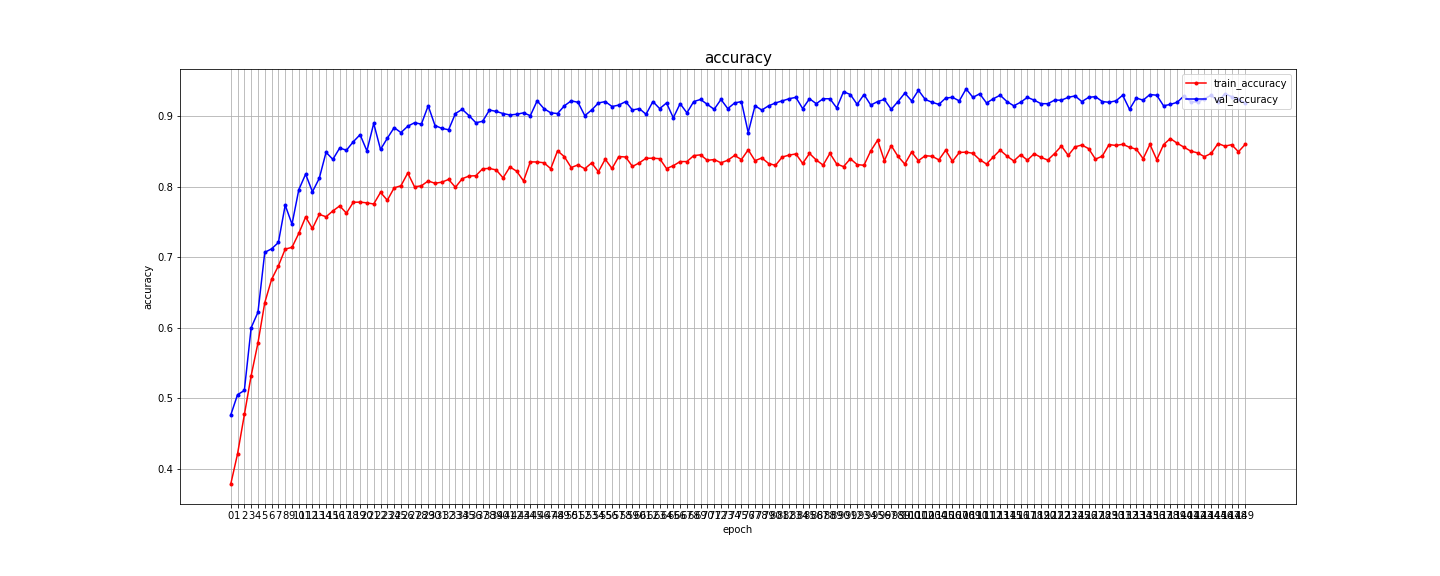

In [16]:
acc_plot_path = os.path.join(RECORDER_DIR, 'plots/accuracy.png')
Image.open(acc_plot_path)

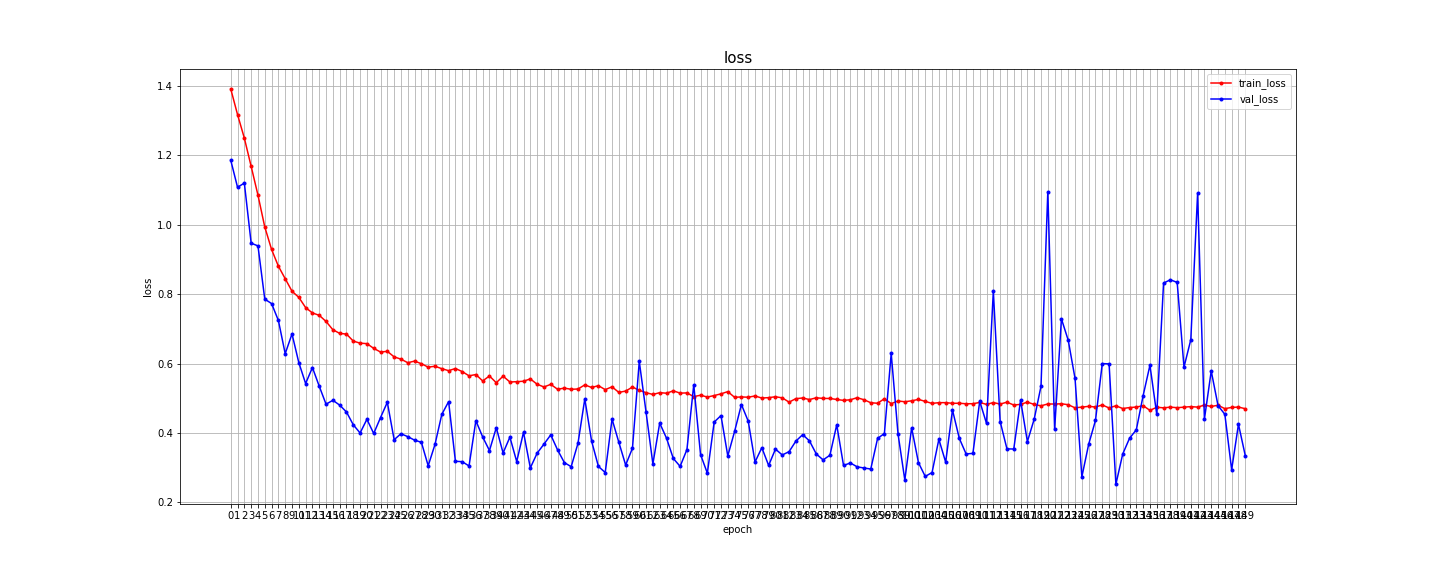

In [17]:
loss_plot_path = os.path.join(RECORDER_DIR, 'plots/loss.png')
Image.open(loss_plot_path)

## Predict

In [18]:
# Predict directory
PREDICT_DIR = os.path.join(PROJECT_DIR, 'results', 'predict', train_serial)
os.makedirs(PREDICT_DIR, exist_ok=True)

DATA_DIR = './data/images/test'
SAMPLE_DIR = './sample_submission.csv' 

# Load data
test_dataset = TestDataset(img_folder=os.path.join(DATA_DIR, 'images'),
                            dfpath=os.path.join(DATA_DIR, 'test_images.csv'))
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            num_workers=num_workers, 
                            shuffle=False,
                            pin_memory=pin_memory,
                            drop_last=drop_last)

# Load model 
pt_path = os.path.join(RECORDER_DIR, 'model.pt')
checkpoint = torch.load(pt_path)
model.load_state_dict(checkpoint['model'])

model.eval()

# Make predictions
y_preds = []
filenames = []

for batch_index, (x, filename) in enumerate(tqdm(test_dataloader)):
    x = x.to(device, dtype=torch.float)
    y_logits = model(x).cpu()
    y_pred = torch.argmax(y_logits, dim=1)
    y_logits = y_logits.detach().numpy()
    y_pred = y_pred.detach().numpy()
    for fname in filename:
        filenames.append(fname)
    for yp in y_pred:
        y_preds.append(yp)

# Decode Prediction Labels
label_decoding = {0:'1++', 1:'1+', 2:'1', 3:'2', 4:'3'}
pred_df = pd.DataFrame(list(zip(filenames, y_preds)), columns=['id','grade'])
pred_df['grade'] = pred_df['grade'].replace(label_decoding)

# Reorder 
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['id'])
resdf = pred_df.set_index('id')
result = resdf.loc[sorter].reset_index()

# Save predictions
resultpath = os.path.join(PREDICT_DIR, 'predictions.csv')
result.to_csv(resultpath, index=False)
print('Done')

100%|██████████| 271/271 [00:20<00:00, 13.21it/s]

Done
